In [1]:
import gym


#定义环境
class MyWrapper(gym.Wrapper):
    def __init__(self):
        env = gym.make('Pendulum-v1', render_mode='rgb_array')
        super().__init__(env)
        self.env = env
        self.step_n = 0

    def reset(self):
        state, _ = self.env.reset()
        self.step_n = 0
        return state

    def step(self, action):
        state, reward, terminated, truncated, info = self.env.step(action)
        done = terminated or truncated
        self.step_n += 1
        if self.step_n >= 200:
            done = True
        return state, reward, done, info


env = MyWrapper()

env.reset()

array([0.95878977, 0.28411648, 0.01650543], dtype=float32)

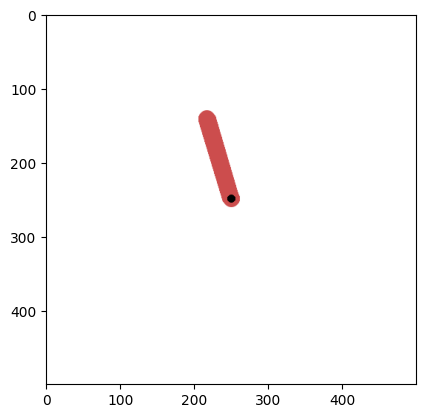

In [2]:
from matplotlib import pyplot as plt

%matplotlib inline


#打印游戏
def show():
    plt.imshow(env.render())
    plt.show()


show()

In [3]:
import torch
import random
from IPython import display
import math


class SAC:
    class ModelAction(torch.nn.Module):
        def __init__(self):
            super().__init__()
            self.fc_state = torch.nn.Sequential(
                torch.nn.Linear(3, 128),
                torch.nn.ReLU(),
            )
            self.fc_mu = torch.nn.Linear(128, 1)
            self.fc_std = torch.nn.Sequential(
                torch.nn.Linear(128, 1),
                torch.nn.Softplus(),
            )

        def forward(self, state):
            #[b, 3] -> [b, 128]
            state = self.fc_state(state)

            #[b, 128] -> [b, 1]
            mu = self.fc_mu(state)

            #[b, 128] -> [b, 1]
            std = self.fc_std(state)

            #根据mu和std定义b个正态分布
            dist = torch.distributions.Normal(mu, std)

            #采样b个样本
            #这里用的是rsample,表示重采样,其实就是先从一个标准正态分布中采样,然后乘以标准差,加上均值
            sample = dist.rsample()

            #样本压缩到-1,1之间,求动作
            action = torch.tanh(sample)

            #求概率对数
            log_prob = dist.log_prob(sample)

            #这个式子看不懂,但参照上下文理解,这个值应该描述的是动作的熵
            entropy = log_prob - (1 - action.tanh()**2 + 1e-7).log()
            entropy = -entropy

            return action * 2, entropy

    class ModelValue(torch.nn.Module):
        def __init__(self):
            super().__init__()
            self.sequential = torch.nn.Sequential(
                torch.nn.Linear(4, 128),
                torch.nn.ReLU(),
                torch.nn.Linear(128, 128),
                torch.nn.ReLU(),
                torch.nn.Linear(128, 1),
            )

        def forward(self, state, action):
            #[b, 3+1] -> [b, 4]
            state = torch.cat([state, action], dim=1)

            #[b, 4] -> [b, 1]
            return self.sequential(state)

    def __init__(self):
        self.model_action = self.ModelAction()

        self.model_value1 = self.ModelValue()
        self.model_value2 = self.ModelValue()

        self.model_value_next1 = self.ModelValue()
        self.model_value_next2 = self.ModelValue()

        self.model_value_next1.load_state_dict(self.model_value1.state_dict())
        self.model_value_next2.load_state_dict(self.model_value2.state_dict())

        #这也是一个可学习的参数
        self.alpha = torch.tensor(math.log(0.01))
        self.alpha.requires_grad = True

        self.optimizer_action = torch.optim.Adam(
            self.model_action.parameters(), lr=3e-4)
        self.optimizer_value1 = torch.optim.Adam(
            self.model_value1.parameters(), lr=3e-3)
        self.optimizer_value2 = torch.optim.Adam(
            self.model_value2.parameters(), lr=3e-3)

        #alpha也是要更新的参数,所以这里要定义优化器
        self.optimizer_alpha = torch.optim.Adam([self.alpha], lr=3e-4)

        self.loss_fn = torch.nn.MSELoss()

    def get_action(self, state):
        state = torch.FloatTensor(state).reshape(1, 3)
        action, _ = self.model_action(state)
        return action.item()

    def test(self, play):
        #初始化游戏
        state = env.reset()

        #记录反馈值的和,这个值越大越好
        reward_sum = 0

        #玩到游戏结束为止
        over = False
        while not over:
            #根据当前状态得到一个动作
            action = self.get_action(state)

            #执行动作,得到反馈
            state, reward, over, _ = env.step([action])
            reward_sum += reward

            #打印动画
            if play and random.random() < 0.2:  #跳帧
                display.clear_output(wait=True)
                show()

        return reward_sum

    def _soft_update(self, model, model_next):
        for param, param_next in zip(model.parameters(),
                                     model_next.parameters()):
            #以一个小的比例更新
            value = param_next.data * 0.995 + param.data * 0.005
            param_next.data.copy_(value)

    def _get_target(self, reward, next_state, over):
        #首先使用model_action计算动作和动作的熵
        #[b, 4] -> [b, 1],[b, 1]
        action, entropy = self.model_action(next_state)

        #评估next_state的价值
        #[b, 4],[b, 1] -> [b, 1]
        target1 = self.model_value_next1(next_state, action)
        target2 = self.model_value_next2(next_state, action)

        #取价值小的,这是出于稳定性考虑
        #[b, 1]
        target = torch.min(target1, target2)

        #exp和log互为反操作,这里是把alpha还原了
        #这里的操作是在target上加上了动作的熵,alpha作为权重系数
        #[b, 1] - [b, 1] -> [b, 1]
        target += self.alpha.exp() * entropy

        #[b, 1]
        target *= 0.99
        target *= (1 - over)
        target += reward

        return target

    def _get_loss_action(self, state):
        #计算action和熵
        #[b, 3] -> [b, 1],[b, 1]
        action, entropy = self.model_action(state)

        #使用两个value网络评估action的价值
        #[b, 3],[b, 1] -> [b, 1]
        value1 = self.model_value1(state, action)
        value2 = self.model_value2(state, action)

        #取价值小的,出于稳定性考虑
        #[b, 1]
        value = torch.min(value1, value2)

        #alpha还原后乘以熵,这个值期望的是越大越好,但是这里是计算loss,所以符号取反
        #[1] - [b, 1] -> [b, 1]
        loss_action = -self.alpha.exp() * entropy

        #减去value,所以value越大越好,这样loss就会越小
        loss_action -= value

        return loss_action.mean(), entropy

    def _get_loss_value(self, model_value, target, state, action, next_state):
        #计算value
        value = model_value(state, action)

        #计算loss,value的目标是要贴近target
        loss_value = self.loss_fn(value, target)
        return loss_value

    def train(self, state, action, reward, next_state, over):
        #对reward偏移,为了便于训练
        reward = (reward + 8) / 8

        #计算target,这个target里已经考虑了动作的熵
        #[b, 1]
        target = self._get_target(reward, next_state, over)
        target = target.detach()

        #计算两个value loss
        loss_value1 = self._get_loss_value(self.model_value1, target, state,
                                           action, next_state)
        loss_value2 = self._get_loss_value(self.model_value2, target, state,
                                           action, next_state)

        #更新参数
        self.optimizer_value1.zero_grad()
        loss_value1.backward()
        self.optimizer_value1.step()

        self.optimizer_value2.zero_grad()
        loss_value2.backward()
        self.optimizer_value2.step()

        #使用model_value计算model_action的loss
        loss_action, entropy = self._get_loss_action(state)
        self.optimizer_action.zero_grad()
        loss_action.backward()
        self.optimizer_action.step()

        #熵乘以alpha就是alpha的loss
        #[b, 1] -> [1]
        loss_alpha = (entropy + 1).detach() * self.alpha.exp()
        loss_alpha = loss_alpha.mean()

        #更新alpha值
        self.optimizer_alpha.zero_grad()
        loss_alpha.backward()
        self.optimizer_alpha.step()

        #增量更新next模型
        self._soft_update(self.model_value1, self.model_value_next1)
        self._soft_update(self.model_value2, self.model_value_next2)


teacher = SAC()

teacher.train(
    torch.randn(5, 3),
    torch.randn(5, 1),
    torch.randn(5, 1),
    torch.randn(5, 3),
    torch.zeros(5, 1).long(),
)

teacher.get_action([1, 2, 3]), teacher.test(play=False)

(0.7330804467201233, -1643.4524453536155)

In [4]:
class Data:
    def __init__(self):
        #样本池
        self.datas = []

    #向样本池中添加N条数据,删除M条最古老的数据
    def update_data(self, agent):
        #初始化游戏
        state = env.reset()

        #玩到游戏结束为止
        over = False
        while not over:
            #根据当前状态得到一个动作
            action = agent.get_action(state)

            #执行动作,得到反馈
            next_state, reward, over, _ = env.step([action])

            #记录数据样本
            self.datas.append((state, action, reward, next_state, over))

            #更新游戏状态,开始下一个动作
            state = next_state

        #数据上限,超出时从最古老的开始删除
        while len(self.datas) > 100000:
            self.datas.pop(0)

    #获取一批数据样本
    def get_sample(self):
        #从样本池中采样
        samples = random.sample(self.datas, 64)

        #[b, 3]
        state = torch.FloatTensor([i[0] for i in samples]).reshape(-1, 3)
        #[b, 1]
        action = torch.FloatTensor([i[1] for i in samples]).reshape(-1, 1)
        #[b, 1]
        reward = torch.FloatTensor([i[2] for i in samples]).reshape(-1, 1)
        #[b, 3]
        next_state = torch.FloatTensor([i[3] for i in samples]).reshape(-1, 3)
        #[b, 1]
        over = torch.LongTensor([i[4] for i in samples]).reshape(-1, 1)

        return state, action, reward, next_state, over


data = Data()

data.update_data(teacher), data.get_sample()

(None,
 (tensor([[-0.8575,  0.5145,  1.0999],
          [-0.9950, -0.0999,  0.6269],
          [-0.9976, -0.0696, -0.3445],
          [-0.6277,  0.7784,  0.6930],
          [-0.9890,  0.1481,  1.5233],
          [-0.9988, -0.0487,  0.6833],
          [-0.9976, -0.0687,  0.4000],
          [-0.5871,  0.8095, -0.0198],
          [-0.7996,  0.6005,  2.0485],
          [-0.9924,  0.1227, -0.8042],
          [-0.9389, -0.3443, -1.0361],
          [-0.9747, -0.2235,  1.3453],
          [-0.9992,  0.0389, -0.1037],
          [-0.8812, -0.4727, -0.4140],
          [-0.9994,  0.0332,  0.1138],
          [-0.9921, -0.1254,  0.9562],
          [-0.9966,  0.0827, -1.1571],
          [-0.9553,  0.2955,  1.5718],
          [-0.9772,  0.2125,  0.6995],
          [-0.9802,  0.1979, -0.8481],
          [-0.9051,  0.4251, -1.5589],
          [-0.9016,  0.4325,  0.8630],
          [-0.8515,  0.5243, -0.1164],
          [-0.9867,  0.1627, -0.4525],
          [-0.9631, -0.2692, -3.8166],
          [-0.9164

In [5]:
for epoch in range(100):
    #更新N条数据
    data.update_data(teacher)

    #每次更新过数据后,学习N次
    for i in range(200):
        teacher.train(*data.get_sample())

    if epoch % 10 == 0:
        test_result = sum([teacher.test(play=False) for _ in range(10)]) / 10
        print(epoch, test_result)

0 -1191.669590342427
10 -1155.2899091132763
20 -1612.6655150976717
30 -1357.096313048631
40 -349.71248661166544
50 -700.6887568917681
60 -823.3950230099035
70 -731.2046245584472
80 -144.5438052028179
90 -111.65458076799659


In [6]:
class CQL(SAC):
    def __init__(self):
        super().__init__()

    def _get_loss_value(self, model_value, target, state, action, next_state):
        #计算value
        value = model_value(state, action)

        #计算loss,value的目标是要贴近target
        loss_value = self.loss_fn(value, target)
        """以上与SAC相同,以下是CQL的部分"""

        #把state复制5遍
        state = state.unsqueeze(dim=1)
        state = state.repeat(1, 5, 1).reshape(-1, 3)

        #把next_state复制5遍
        #[b, 3] -> [b, 1, 3]
        next_state = next_state.unsqueeze(1)
        #[b, 1, 3] -> [b, 5, 3] -> [b*5, 3]
        next_state = next_state.repeat(1, 5, 1).reshape(-1, 3)

        #随机一批动作,数量是数据量的5倍,值域在-1到1之间
        rand_action = torch.empty([len(state), 1]).uniform_(-1, 1)

        #计算state的动作和熵
        #[b*5, 3] -> [b*5, 1],[b*5, 1]
        curr_action, curr_entropy = self.model_action(state)

        #计算next_state的动作和熵
        #[b*5, 3] -> [b*5, 1],[b*5, 1]
        next_action, next_entropy = self.model_action(next_state)

        #计算三份动作分别的value
        #[b*5, 1],[b*5, 1] -> [b*5, 1] -> [b, 5, 1]
        value_rand = model_value(state, rand_action).reshape(-1, 5, 1)
        #[b*5, 1],[b*5, 1] -> [b*5, 1] -> [b, 5, 1]
        value_curr = model_value(state, curr_action).reshape(-1, 5, 1)
        #[b*5, 1],[b*5, 1] -> [b*5, 1] -> [b, 5, 1]
        value_next = model_value(state, next_action).reshape(-1, 5, 1)

        #[b*5, 1] -> [b, 5, 1]
        curr_entropy = curr_entropy.detach().reshape(-1, 5, 1)
        next_entropy = next_entropy.detach().reshape(-1, 5, 1)

        #三份value分别减去他们的熵
        #[b, 5, 1]
        value_rand -= math.log(0.5)
        #[b, 5, 1]
        value_curr -= curr_entropy
        #[b, 5, 1]
        value_next -= next_entropy

        #拼合三份value
        #[b, 5+5+5, 1] -> [b, 15, 1]
        value_cat = torch.cat([value_rand, value_curr, value_next], dim=1)

        #等价t.logsumexp(dim=1), t.exp().sum(dim=1).log()
        #[b, 15, 1] -> [b, 1] -> scala
        loss_cat = torch.logsumexp(value_cat, dim=1).mean()

        #在原本的loss上增加上这一部分
        #scala
        loss_value += 5.0 * (loss_cat - value.mean())
        """CQL算法和SCA算法的差异到此为止"""

        return loss_value


student = CQL()

student.train(
    torch.randn(5, 3),
    torch.randn(5, 1),
    torch.randn(5, 1),
    torch.randn(5, 3),
    torch.zeros(5, 1).long(),
)

student.get_action([1, 2, 3]), student.test(play=False)

(-1.7815548181533813, -1513.1286141790065)

In [8]:
#训练N次,训练过程中不需要更新数据
for i in range(50000):
    #采样一批数据
    student.train(*data.get_sample())

    if i % 2000 == 0:
        test_result = sum([student.test(play=False) for _ in range(10)]) / 10
        print(i, test_result)

0 -1311.025866669426
2000 -912.0954630884487
4000 -381.1426011292569
6000 -475.7436788080395
8000 -571.308119324903
10000 -557.3846798710574
12000 -351.51184253246527
14000 -737.5261783022646
16000 -533.6833954872317
18000 -419.3709548261987
20000 -666.2548385709767
22000 -734.8301856097612
24000 -885.9918666290581
26000 -551.6000112476158
28000 -560.0620483852484
30000 -933.4139934630114
32000 -360.8237455410657
34000 -833.4917443377905
36000 -260.9713534856566
38000 -800.5712740533719
40000 -373.75356499111786
42000 -757.2715911544987
44000 -731.975856719401
46000 -828.5287536989603
48000 -522.9316518671445


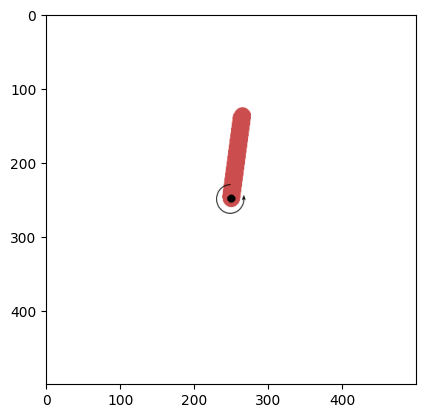

-486.2209349178763

In [11]:
student.test(play=True)